# ARCO ERA5

This notebook demonstrates how to load [ARCO ERA5](https://cloud.google.com/storage/docs/public-datasets/era5) data from Google Cloud Storage through the pycontrails `ARCOERA5` interface.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from pycontrails import Flight, MetDataset
from pycontrails.datalib.ecmwf import ARCOERA5
from pycontrails.models.cocip import Cocip
from pycontrails.models.humidity_scaling import ConstantHumidityScaling
from pycontrails.models.issr import ISSR
from pycontrails.models.ps_model import PSFlight
from pycontrails.physics import units

Load 13 hours of pressure level and single level data from the ARCO ERA5 dataset.

In [2]:
time = ("2019-01-01T00", "2019-01-01T12")

era5_pl = ARCOERA5(
    time=time,
    variables=(*Cocip.met_variables, *Cocip.optional_met_variables),
    n_jobs=4,
)
met = era5_pl.open_metdataset()


era5_sl = ARCOERA5(
    time=time,
    variables=Cocip.rad_variables,
    pressure_levels=-1,
)
rad = era5_sl.open_metdataset()

## ISSRs

Visualize ISSRs over common cruise altitudes over the continental US.

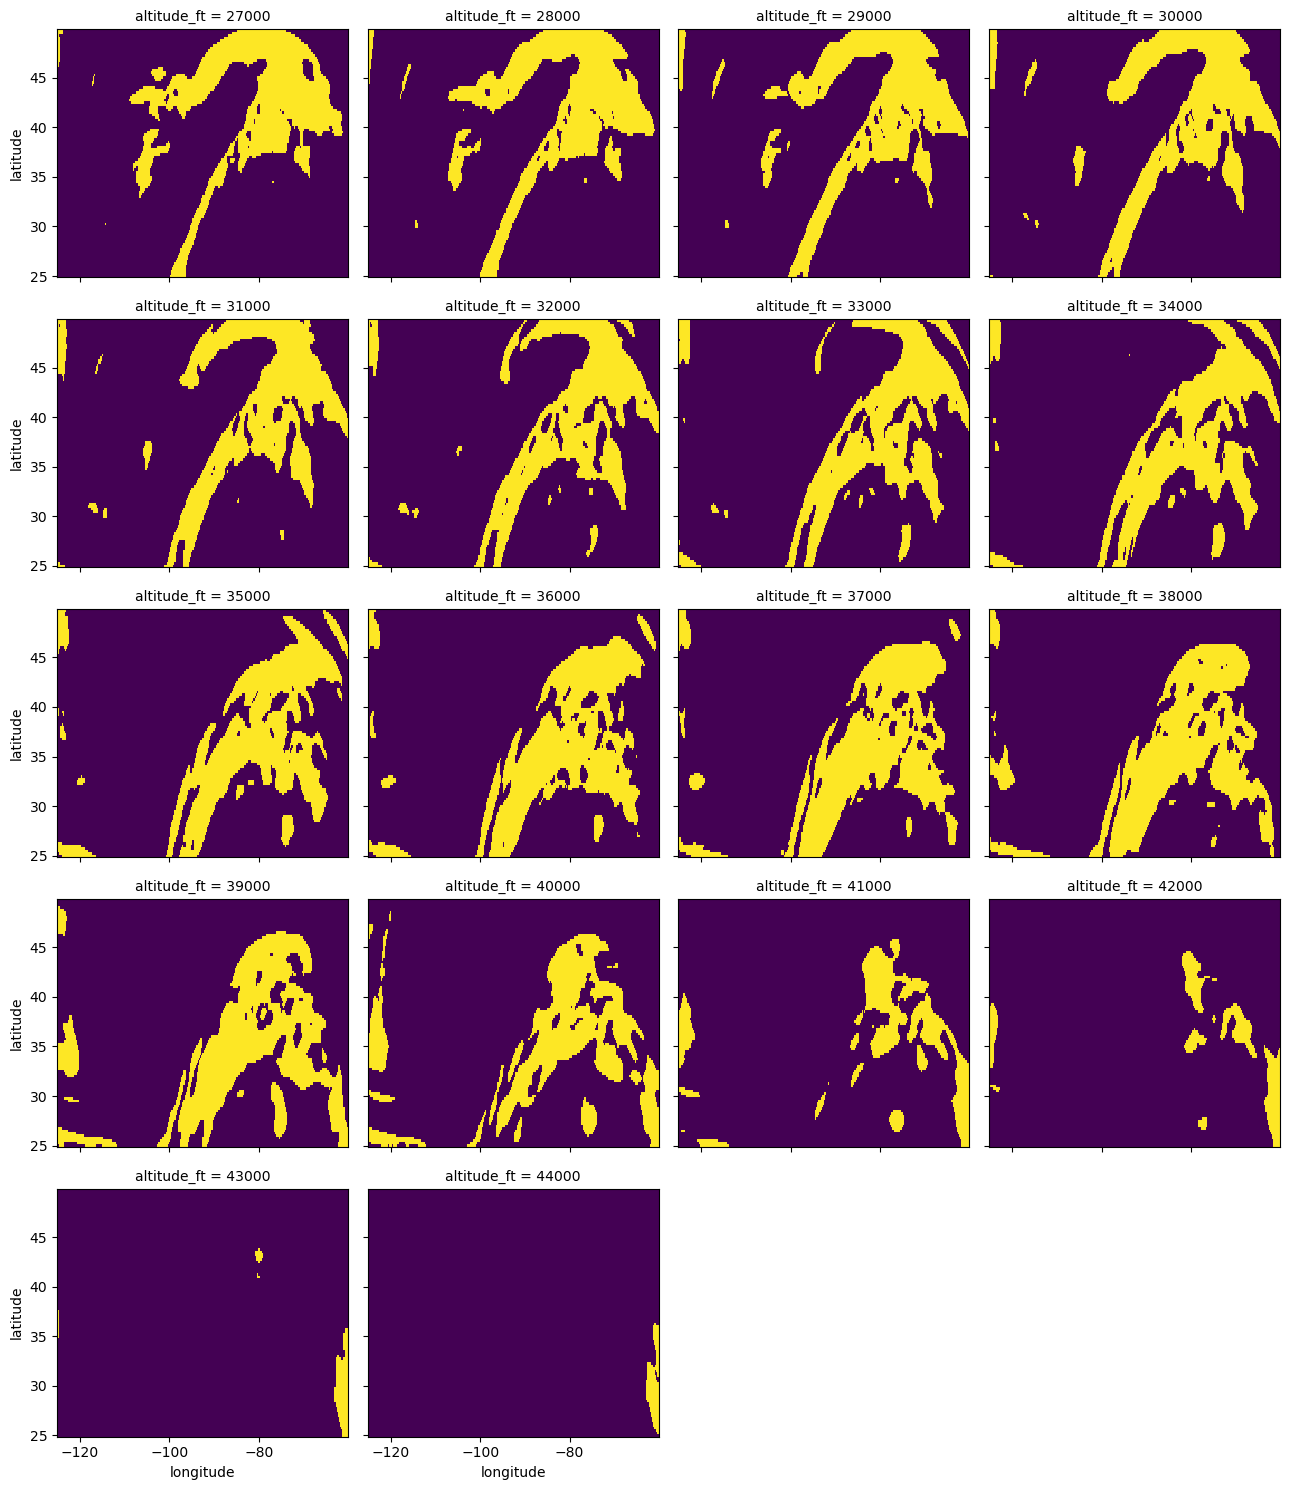

In [3]:
issr = ISSR(met=met, humidity_scaling=ConstantHumidityScaling(rhi_adj=0.95))
source = MetDataset(
    xr.Dataset(
        coords={
            "time": ["2019-01-01T00"],
            "longitude": np.arange(-125, -60, 0.25),
            "latitude": np.arange(25, 50, 0.25),
            "level": units.ft_to_pl(np.arange(27000, 45000, 1000)),
        }
    )
)
da = issr.eval(source).data["issr"]

# Use altitude_ft as the vertical coordinate for plotting
da["altitude_ft"] = units.pl_to_ft(da["level"]).round().astype(int)
da = da.swap_dims(level="altitude_ft")
da = da.sel(altitude_ft=da["altitude_ft"].values[::-1])

da.squeeze().plot(x="longitude", y="latitude", col="altitude_ft", col_wrap=4, add_colorbar=False);

## CoCiP

Run CoCiP on a collection of synthetic flights at different cruise altitudes over the continental US.

The flights constructed below are in no way realistic. They are simply used to showcase running CoCiP with model level met data.

In [4]:
jfk = 40.64, -73.78
lax = 33.94, -118.40

fl_list = [
    Flight(
        longitude=[lax[1], jfk[1]],
        latitude=[lax[0], jfk[0]],
        altitude_ft=[altitude_ft, altitude_ft],
        time=[np.datetime64("2019-01-01T00"), np.datetime64("2019-01-01T04:30")],
        aircraft_type="B738",
        flight_id=f"cruise {altitude_ft} ft",
        origin="LAX",
        destination="JFK",
    ).resample_and_fill()
    for altitude_ft in range(27000, 45000, 1000)
]

In [5]:
cocip = Cocip(
    met=met,
    rad=rad,
    dt_integration="1min",
    max_age="8h",
    aircraft_performance=PSFlight(),
    humidity_scaling=ConstantHumidityScaling(rhi_adj=0.95),
)
fl_list = cocip.eval(fl_list)

## Visualize CoCiP results

Visualize the results of CoCiP on the synthetic flights.

In [6]:
summary = {fl.attrs["flight_id"]: fl["ef"].sum() / 1e12 for fl in fl_list}
pd.Series(summary).to_frame("Energy Forcing [TJ]").astype(int)

,Energy Forcing [TJ]
cruise 27000 ft,0
cruise 28000 ft,4
cruise 29000 ft,44
cruise 30000 ft,18
cruise 31000 ft,0
cruise 32000 ft,0
cruise 33000 ft,0
cruise 34000 ft,0
cruise 35000 ft,50
cruise 36000 ft,88


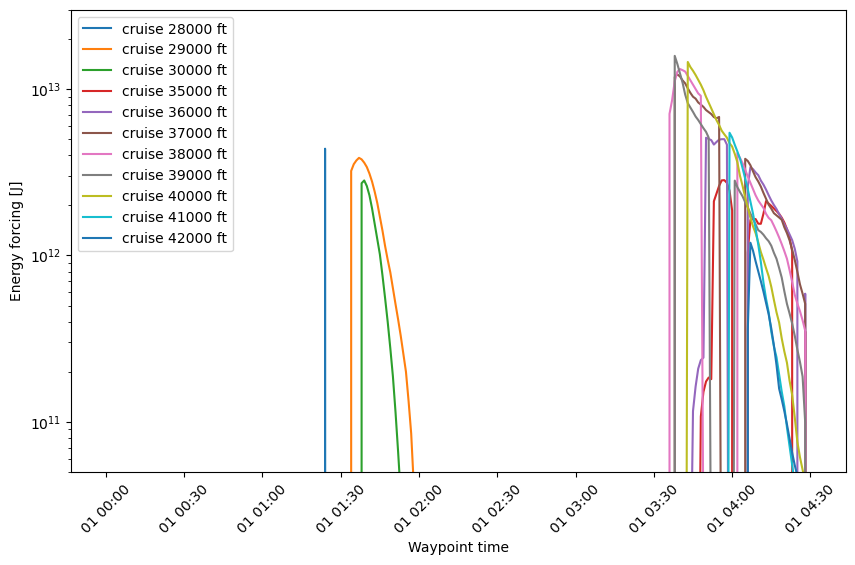

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))

for fl in fl_list:
    if fl["ef"].any():
        ax.plot(fl["time"], fl["ef"], label=fl.attrs["flight_id"])


ax.set_ylabel("Energy forcing [J]")
ax.set_xlabel("Waypoint time")

for tick in ax.get_xticklabels():
    tick.set_rotation(45)

ax.set_yscale("log")
ax.set_ylim(5e10, 3e13)

ax.legend();